# **Redes Neurais**
## **Modelo 2 - Self-Organizing Maps (SOM)**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

## **Instruções**
### **PROJETO 2 – APRENDIZADO NÃO-SUPERVISIONADO**


- Selecionar pelo menos dois datasets;

- Aplicar um modelo neural não supervisionado

- Avaliar os padrões detectados em cada conjunto:
  - Clusters / outliers, etc.

- Avaliar a homogeneidade dos agrupamentos

- Variar os parâmetros do modelo (grid, taxas, número de neurônios, etc.)

### **1. Datasets escolhidos**

#### **Dataset 1: MNIST (Dígitos Manuscritos)**
**Fonte**: `keras.datasets.mnist` | [Original: Yann LeCun](http://yann.lecun.com/exdb/mnist/)
- Ano: 1998
- Samples: 70.000 (60k treino + 10k teste)
- Features: 784 (28x28 pixels)
- Classes: 10 dígitos (0-9)
- **Objetivo**: Descobrir agrupamentos naturais de dígitos sem usar rótulos

#### **Dataset 2: California Housing (Dados Geográficos/Econômicos)**  
**Fonte**: `sklearn.datasets.fetch_california_housing` | [Census 1990](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
- Ano: 1997
- Samples: 20.640
- Features: 8
    - MedInc - Median income in block group
    - HouseAge - Median house age in block group
    - AveRooms - Average number of rooms per household
    - AveBedrms - Average number of bedrooms per household
    - Population - Block group population
    - AveOccup - Average number of household members
    - Latitude - Block group latitude
    - Longitude - Block group longitude
- **Objetivo**: Identificar regiões com perfis socioeconômicos similares e outliers

### **2. Imports e Configuração**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

np.random.seed(42)
tf.random.set_seed(42)

2025-10-29 16:12:21.488173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 16:12:22.796299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 16:12:25.154155: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## **3. Dataset 1 - MNIST**

### **3.1. Carregamento e Pré-processamento**
Carregamento do MNIST e normalização dos pixels (0-1). Para aprendizado não-supervisionado, utilizarei apenas os dados de treino (sem os rótulos para treinar a SOM).

In [2]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_mnist_full = np.concatenate([X_train_mnist, X_test_mnist], axis=0)
y_mnist_full = np.concatenate([y_train_mnist, y_test_mnist], axis=0)

X_mnist_flat = X_mnist_full.reshape(X_mnist_full.shape[0], -1).astype('float32') / 255.0
 
X_mnist_sample = X_mnist_flat[:10000]
y_mnist_sample = y_mnist_full[:10000]

print(f"Dataset completo MNIST: {X_mnist_flat.shape}")
print(f"Sample para SOM: {X_mnist_sample.shape}")
print(f"Pixel range: [{X_mnist_sample.min():.1f}, {X_mnist_sample.max():.1f}]")
print(f"Classes presentes: {np.unique(y_mnist_sample)}")

Dataset completo MNIST: (70000, 784)
Sample para SOM: (10000, 784)
Pixel range: [0.0, 1.0]
Classes presentes: [0 1 2 3 4 5 6 7 8 9]


### **3.2. Visualização dos Dados**
Análise visual de amostras dos dígitos e distribuição das classes.

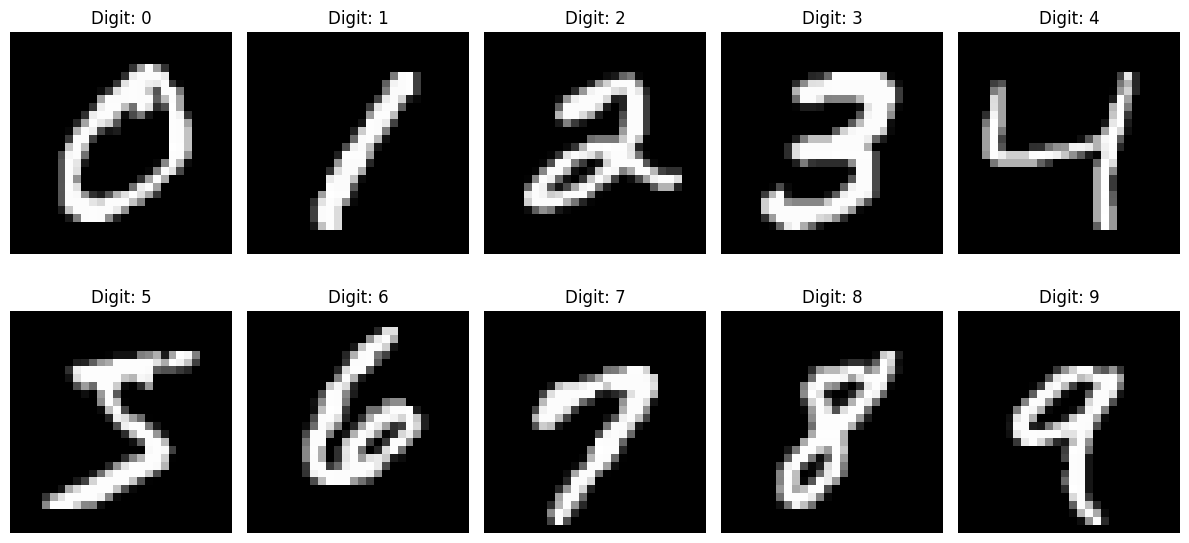

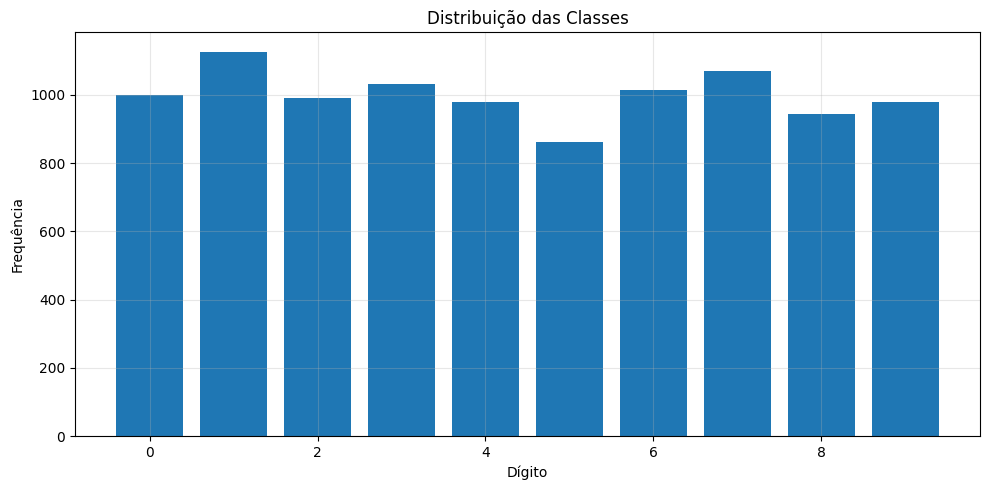

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_mnist_sample == i)[0][0]
    img = X_mnist_sample[idx].reshape(28, 28)
    axes[i//5, i%5].imshow(img, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit: {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

unique, counts = np.unique(y_mnist_sample, return_counts=True)
ax.bar(unique, counts)
ax.set_title('Distribuição das Classes')
ax.set_xlabel('Dígito')
ax.set_ylabel('Frequência')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **3.3. Implementação da Self-Organizing Map (SOM)**
Implementação da rede SOM utilizando TensorFlow/NumPy para aproveitar aceleração por GPU.

In [5]:
class SOM:
    def __init__(self, grid_size, input_dim, learning_rate=0.5, initial_sigma=None, sigma_final=0.5):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.initial_sigma = initial_sigma if initial_sigma else max(grid_size) / 2.0
        self.sigma = self.initial_sigma
        self.sigma_final = sigma_final
        
        self.weights = tf.Variable(
            tf.random.normal([grid_size[0], grid_size[1], input_dim], dtype=tf.float32),
            trainable=False
        )
        
        self.grid_x, self.grid_y = np.meshgrid(
            np.arange(grid_size[0]), 
            np.arange(grid_size[1])
        )
        self.grid_positions = np.stack([self.grid_x.ravel(), self.grid_y.ravel()], axis=1)
    
    def _find_bmu(self, input_vector):
        input_vector = tf.reshape(input_vector, [1, 1, self.input_dim])
        distances = tf.reduce_sum(tf.square(self.weights - input_vector), axis=2)
        bmu_index = tf.argmin(tf.reshape(distances, [-1]))
        bmu_x = bmu_index // self.grid_size[1]
        bmu_y = bmu_index % self.grid_size[1]
        return bmu_x.numpy(), bmu_y.numpy()
    
    def _calculate_influence(self, bmu_position, iteration, total_iterations):
        decay_factor = iteration / total_iterations
        self.sigma = self.initial_sigma * (1 - decay_factor) + self.sigma_final * decay_factor
        
        self.learning_rate = self.initial_learning_rate * np.exp(-iteration / total_iterations)
        
        distances = np.sum((self.grid_positions - bmu_position) ** 2, axis=1)
        influence = np.exp(-distances / (2 * self.sigma ** 2))
        influence = influence.reshape(self.grid_size[0], self.grid_size[1], 1)
        
        return tf.constant(influence, dtype=tf.float32)
    
    def train(self, data, num_iterations, verbose=True):
        total_samples = data.shape[0]
        
        for iteration in range(num_iterations):
            idx = np.random.randint(0, total_samples)
            input_vector = tf.constant(data[idx], dtype=tf.float32)
            
            bmu_x, bmu_y = self._find_bmu(input_vector)
            bmu_position = np.array([bmu_x, bmu_y])
            
            influence = self._calculate_influence(bmu_position, iteration, num_iterations)
            
            delta = self.learning_rate * influence * (input_vector - self.weights)
            self.weights.assign_add(delta)
            
            if verbose and (iteration + 1) % (num_iterations // 10) == 0:
                print(f"Iteration {iteration + 1}/{num_iterations} - LR: {self.learning_rate:.4f} - Sigma: {self.sigma:.4f}")
    
    def get_bmu_map(self, data):
        bmu_map = np.zeros((data.shape[0], 2), dtype=int)
        for i, sample in enumerate(data):
            bmu_x, bmu_y = self._find_bmu(tf.constant(sample, dtype=tf.float32))
            bmu_map[i] = [bmu_x, bmu_y]
        return bmu_map
    
    def calculate_u_matrix(self):
        u_matrix = np.zeros(self.grid_size)
        weights_np = self.weights.numpy()
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neighbors = []
                if i > 0:
                    neighbors.append(weights_np[i-1, j])
                if i < self.grid_size[0] - 1:
                    neighbors.append(weights_np[i+1, j])
                if j > 0:
                    neighbors.append(weights_np[i, j-1])
                if j < self.grid_size[1] - 1:
                    neighbors.append(weights_np[i, j+1])
                
                if neighbors:
                    distances = [np.linalg.norm(weights_np[i, j] - neighbor) for neighbor in neighbors]
                    u_matrix[i, j] = np.mean(distances)
        
        return u_matrix


### **3.4. Configuração dos Experimentos**
12 configurações de grid para avaliar o impacto dos hiperparâmetros. Variações possivelmente adequadas e adversas para cada caso.

- 4 variações para cada tamanho de grid.
  - Initial_sigma -> final_sigma;
  - Learning rate;
  - iterations;
- Grids 10x10, 15x15, 20x20.

In [6]:
som_configs = [
    {"name": "10x10_bom_sigma", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.5, "iterations": 5000},
    {"name": "10x10_sigma_baixo", "grid_size": (10, 10), "initial_sigma": 2.0, "sigma_final": 0.3, "learning_rate": 0.5, "iterations": 5000},
    {"name": "10x10_lr_alto", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.9, "iterations": 5000},
    {"name": "10x10_poucas_iter", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.5, "iterations": 2000},

    {"name": "15x15_bom_sigma", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.5, "iterations": 7500},
    {"name": "15x15_sigma_muito_alto", "grid_size": (15, 15), "initial_sigma": 12.0, "sigma_final": 3.0, "learning_rate": 0.5, "iterations": 7500},
    {"name": "15x15_lr_baixo", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.1, "iterations": 7500},
    {"name": "15x15_muitas_iter", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.5, "iterations": 15000},

    {"name": "20x20_bom_sigma", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 0.5, "iterations": 10000},
    {"name": "20x20_sigma_final_alto", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 5.0, "learning_rate": 0.5, "iterations": 10000},
    {"name": "20x20_lr_muito_alto", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 1.2, "iterations": 10000},
    {"name": "20x20_iter_insuficientes", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 0.5, "iterations": 4000},
]


### **3.5. Treinamento de Todas as Configurações**
Treinamento sistemático de todas as 18 configurações para análise comparativa.

In [7]:
import time

results = []
trained_soms = {}

for idx, config in enumerate(som_configs, 1):
    print(f"\n[{idx}/{len(som_configs)}] Treinando: {config['name']}")
    print(f"    Grid: {config['grid_size']}, Sigma: {config['initial_sigma']}→{config['sigma_final']}, LR: {config['learning_rate']}, Iter: {config['iterations']}")
    print("-" * 90)
    
    som = SOM(
        grid_size=config['grid_size'],
        input_dim=X_mnist_sample.shape[1],
        learning_rate=config['learning_rate'],
        initial_sigma=config['initial_sigma'],
        sigma_final=config['sigma_final']
    )
    
    start_time = time.time()
    som.train(X_mnist_sample, num_iterations=config['iterations'], verbose=False)
    training_time = time.time() - start_time
    
    bmu_map = som.get_bmu_map(X_mnist_sample)
    cluster_labels = bmu_map[:, 0] * som.grid_size[1] + bmu_map[:, 1]
    
    silhouette = silhouette_score(X_mnist_sample, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_mnist_sample, cluster_labels)
    calinski = calinski_harabasz_score(X_mnist_sample, cluster_labels)
    
    active_neurons = len(np.unique(cluster_labels))
    total_neurons = config['grid_size'][0] * config['grid_size'][1]
    utilization = (active_neurons / total_neurons) * 100
    
    result = {
        'name': config['name'],
        'grid_size': f"{config['grid_size'][0]}x{config['grid_size'][1]}",
        'initial_sigma': config['initial_sigma'],
        'sigma_final': config['sigma_final'],
        'learning_rate': config['learning_rate'],
        'iterations': config['iterations'],
        'training_time': training_time,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'active_neurons': active_neurons,
        'total_neurons': total_neurons,
        'utilization': utilization
    }
    
    results.append(result)
    trained_soms[config['name']] = {
        'som': som,
        'bmu_map': bmu_map,
        'cluster_labels': cluster_labels
    }
    
    print(f"    ✓ Concluído em {training_time:.2f}s")
    print(f"    Métricas: Silhouette={silhouette:.4f}, Davies-Bouldin={davies_bouldin:.4f}, Calinski={calinski:.2f}")
    print(f"    Utilização: {active_neurons}/{total_neurons} neurônios ({utilization:.1f}%)")

print("\n" + "=" * 90)
print("TREINAMENTO COMPLETO!")
print("=" * 90)


[1/12] Treinando: 10x10_bom_sigma
    Grid: (10, 10), Sigma: 5.0→1.0, LR: 0.5, Iter: 5000
------------------------------------------------------------------------------------------


I0000 00:00:1761765185.820423    4878 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5414 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


    ✓ Concluído em 4.63s
    Métricas: Silhouette=0.0093, Davies-Bouldin=4.1305, Calinski=65.41
    Utilização: 100/100 neurônios (100.0%)

[2/12] Treinando: 10x10_sigma_baixo
    Grid: (10, 10), Sigma: 2.0→0.3, LR: 0.5, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 2.96s
    Métricas: Silhouette=0.0239, Davies-Bouldin=3.9582, Calinski=79.98
    Utilização: 100/100 neurônios (100.0%)

[3/12] Treinando: 10x10_lr_alto
    Grid: (10, 10), Sigma: 5.0→1.0, LR: 0.9, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 3.46s
    Métricas: Silhouette=0.0045, Davies-Bouldin=4.0985, Calinski=63.01
    Utilização: 100/100 neurônios (100.0%)

[4/12] Treinando: 10x10_poucas_iter
    Grid: (10, 10), Sigma: 5.0→1.0, LR: 0.5, Iter: 2000
------------------------------------------------------------------------------------------
    ✓ Concluído em 1.36s
    Métric

### **3.6. Mapa de Dígitos Dominantes**
Visualização compacta mostrando qual dígito predomina em cada neurônio do grid. Cada cor representa um dígito diferente (0-9), permitindo identificar regiões especializadas e avaliar a separação topológica aprendida pela SOM.

/tmp/ipykernel_4878/261299165.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)


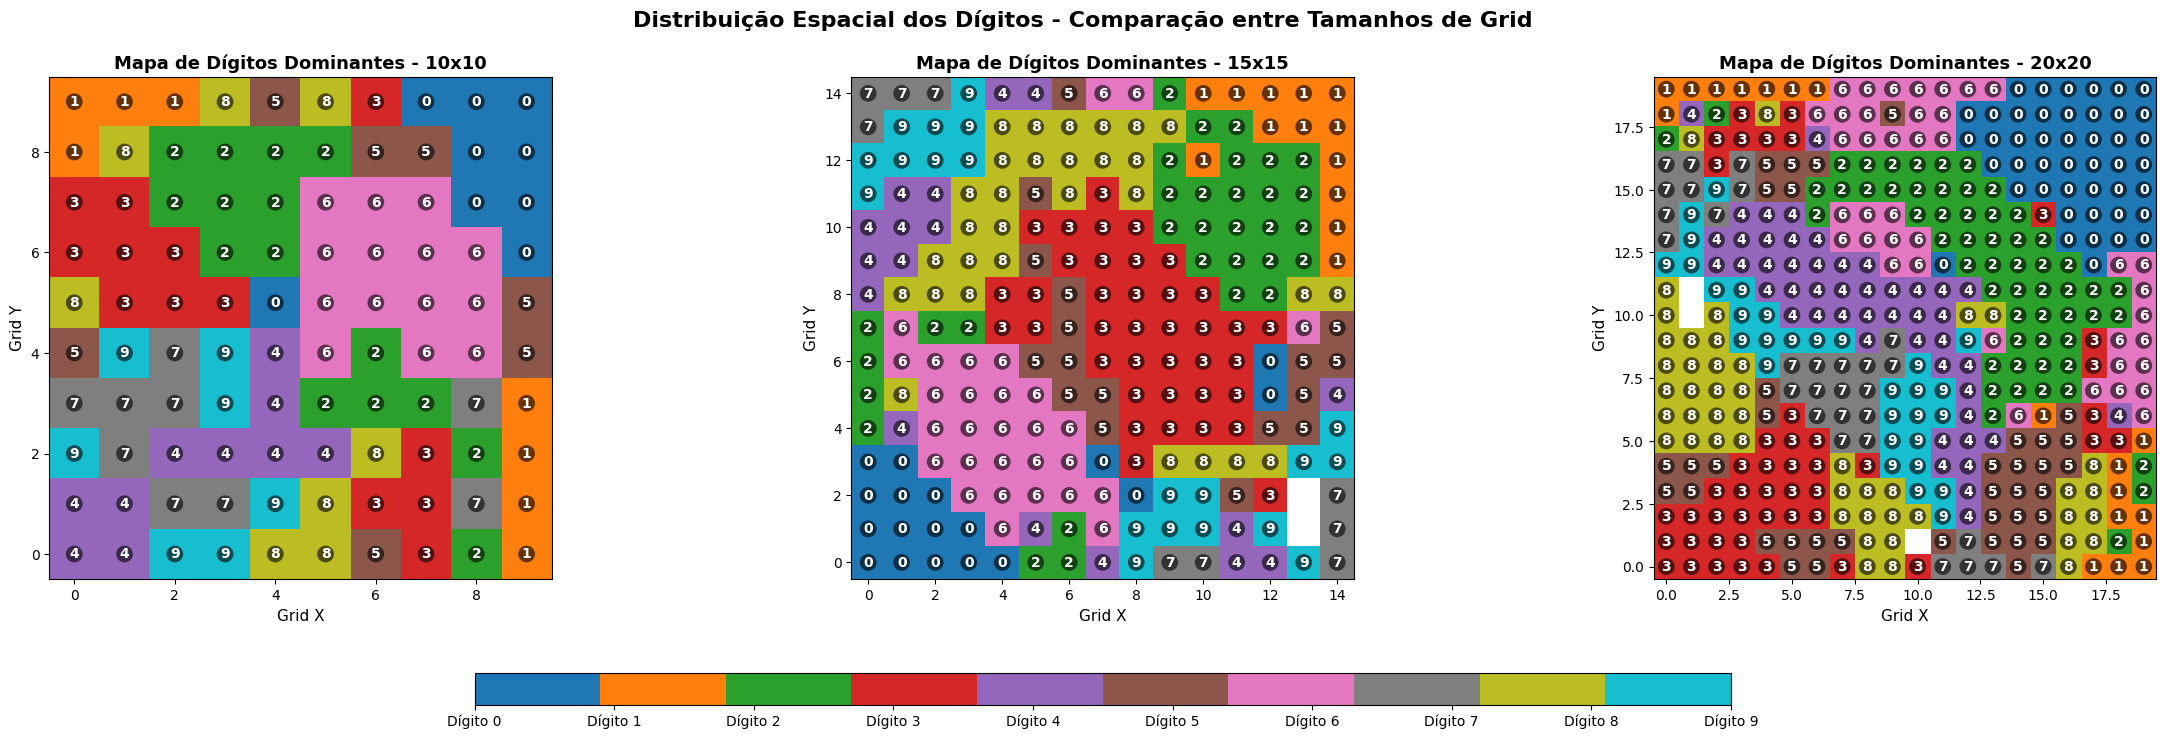

In [16]:
selected_configs = ['10x10_bom_sigma', '15x15_bom_sigma', '20x20_bom_sigma']
grid_labels = ['10x10', '15x15', '20x20']

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

cmap = plt.cm.get_cmap('tab10', 10)
colors = [cmap(i) for i in range(10)]

for idx, config_name in enumerate(selected_configs):
    data = trained_soms[config_name]
    som_obj = data['som']
    bmu_map = data['bmu_map']
    
    dominant_digit_map = np.full(som_obj.grid_size, -1, dtype=int)
    
    for i in range(som_obj.grid_size[0]):
        for j in range(som_obj.grid_size[1]):
            neuron_mask = (bmu_map[:, 0] == i) & (bmu_map[:, 1] == j)
            if neuron_mask.sum() > 0:
                digits_in_neuron = y_mnist_sample[neuron_mask]
                dominant_digit = np.bincount(digits_in_neuron).argmax()
                dominant_digit_map[i, j] = dominant_digit
    
    masked_map = np.ma.masked_where(dominant_digit_map == -1, dominant_digit_map)
    
    im = axes[idx].imshow(masked_map, cmap='tab10', interpolation='nearest', 
                          origin='lower', vmin=0, vmax=9)
    axes[idx].set_title(f'Mapa de Dígitos Dominantes - {grid_labels[idx]}', 
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    
    for i in range(som_obj.grid_size[0]):
        for j in range(som_obj.grid_size[1]):
            if dominant_digit_map[i, j] != -1:
                axes[idx].text(j, i, str(dominant_digit_map[i, j]), 
                              ha='center', va='center', fontsize=10, 
                              color='white', fontweight='bold',
                              bbox=dict(boxstyle='circle,pad=0.1', 
                                       facecolor='black', alpha=0.6, edgecolor='none'))

plt.suptitle('Distribuição Espacial dos Dígitos - Comparação entre Tamanhos de Grid', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.96])

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', 
                     pad=0.15, fraction=0.05, aspect=40)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels([f'Dígito {i}' for i in range(10)])
cbar.ax.tick_params(labelsize=10)

plt.show()

### **3.7. Hits Map - Todas as Configurações**
Mapa de ativação dos neurônios mostrando a frequência total com que cada posição do grid foi ativada como BMU (Best Matching Unit) por todas as amostras.

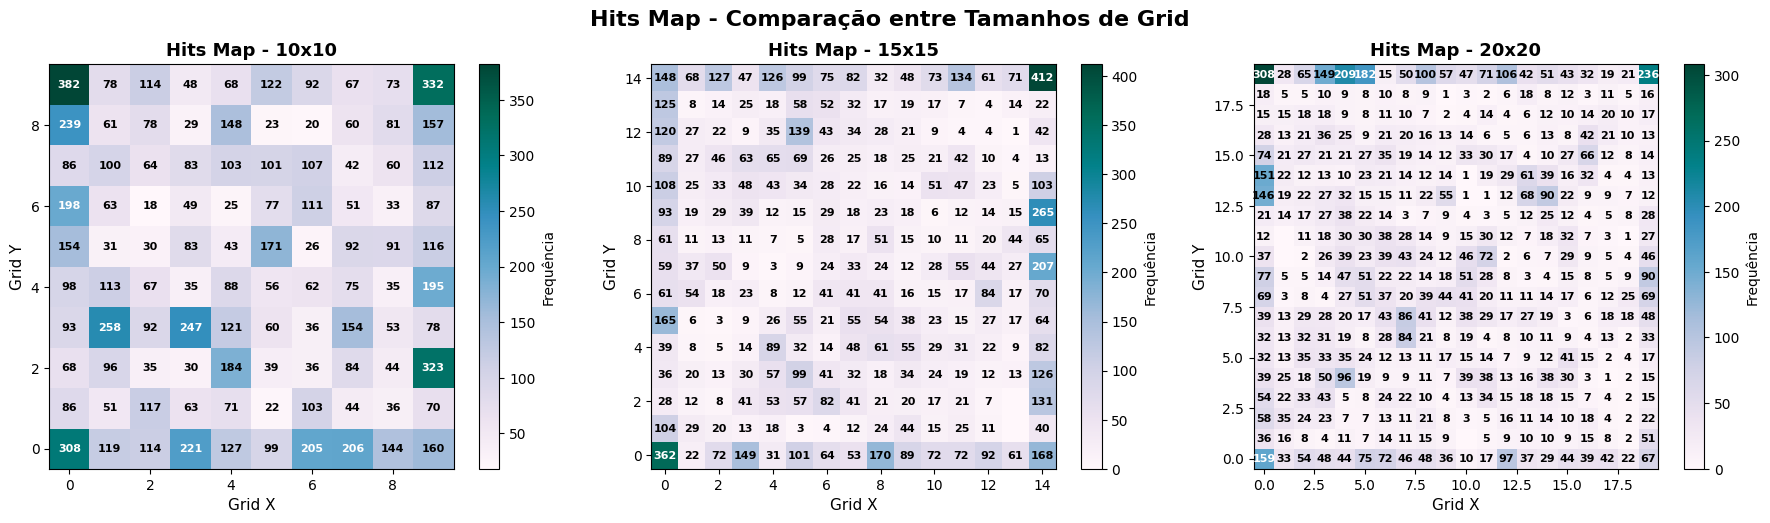

In [9]:
selected_configs = ['10x10_bom_sigma', '15x15_bom_sigma', '20x20_bom_sigma']
grid_labels = ['10x10', '15x15', '20x20']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, config_name in enumerate(selected_configs):
    data = trained_soms[config_name]
    som_obj = data['som']
    bmu_map = data['bmu_map']
    
    hits_map = np.zeros(som_obj.grid_size)
    for bmu in bmu_map:
        hits_map[bmu[0], bmu[1]] += 1
    
    active_neurons = np.count_nonzero(hits_map)
    total_neurons = som_obj.grid_size[0] * som_obj.grid_size[1]
    utilization = (active_neurons / total_neurons) * 100
    
    im = axes[idx].imshow(hits_map, cmap='PuBuGn', interpolation='nearest', origin='lower')
    axes[idx].set_title(f'\nHits Map - {grid_labels[idx]}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    plt.colorbar(im, ax=axes[idx], label='Frequência')
    
    for i in range(som_obj.grid_size[0]):
        for j in range(som_obj.grid_size[1]):
            if hits_map[i, j] > 0:
                axes[idx].text(j, i, f'{int(hits_map[i, j])}', 
                              ha='center', va='center', fontsize=8, 
                              color='white' if hits_map[i, j] > hits_map.max()*0.5 else 'black',
                              fontweight='bold')

plt.suptitle('Hits Map - Comparação entre Tamanhos de Grid', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **3.8. U-Matrix - Todas as Configurações**
Matriz de distâncias unificada mostrando a distância média entre os vetores de pesos de cada neurônio e seus vizinhos. Valores altos (cores quentes) indicam fronteiras entre clusters; valores baixos (cores frias) indicam regiões homogêneas.

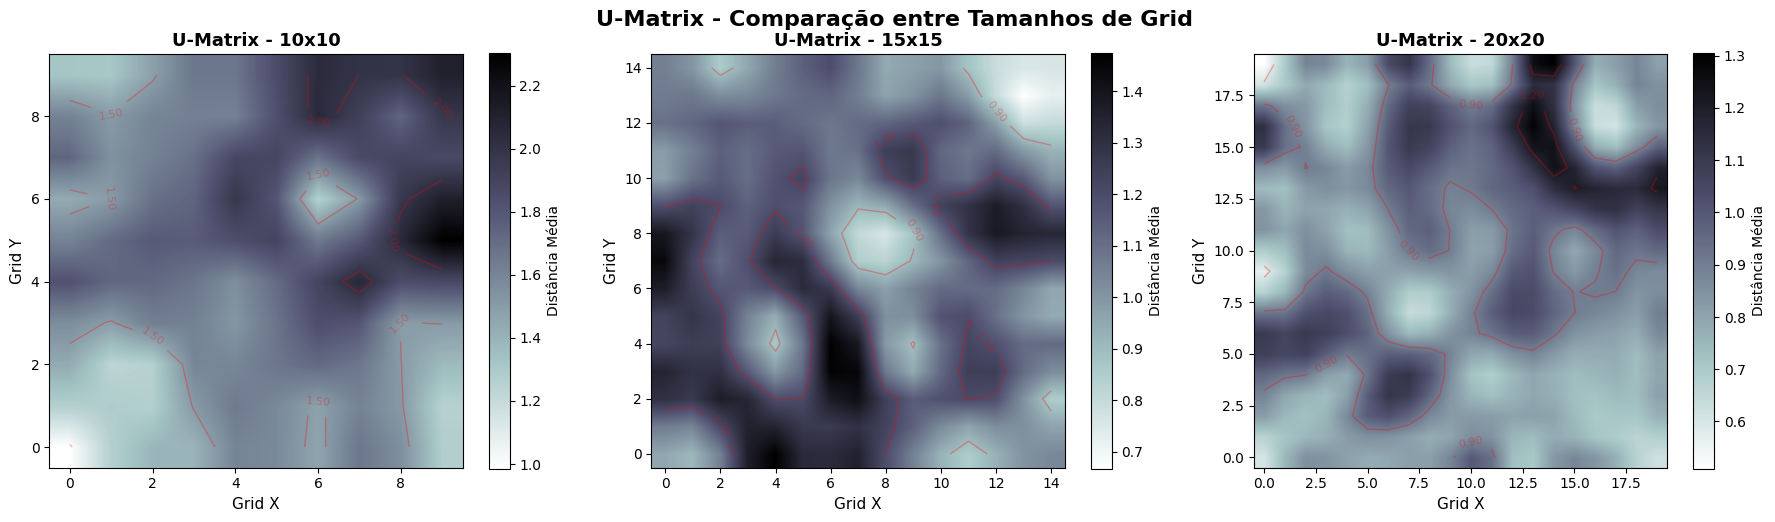

In [10]:
selected_configs = ['10x10_bom_sigma', '15x15_bom_sigma', '20x20_bom_sigma']
grid_labels = ['10x10', '15x15', '20x20']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, config_name in enumerate(selected_configs):
    data = trained_soms[config_name]
    som_obj = data['som']
    
    u_matrix = som_obj.calculate_u_matrix()
    
    im = axes[idx].imshow(u_matrix, cmap='bone_r', interpolation='bilinear', origin='lower')
    axes[idx].set_title(f'U-Matrix - {grid_labels[idx]}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    plt.colorbar(im, ax=axes[idx], label='Distância Média')

    contours = axes[idx].contour(u_matrix, levels=2, colors='red', alpha=0.3, linewidths=1)
    axes[idx].clabel(contours, inline=True, fontsize=8, fmt='%.2f')


plt.suptitle('U-Matrix - Comparação entre Tamanhos de Grid', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **3.9. Análise Comparativa de Métricas**
Comparação quantitativa das métricas de qualidade dos clusters entre todas as configurações treinadas.

In [18]:
results_df = pd.DataFrame(results)

print("=" * 140)
print("RESUMO COMPARATIVO - TODAS AS CONFIGURAÇÕES")
print("=" * 140)
print(results_df.to_string(index=False))
print("=" * 140)

results_df_sorted = results_df.sort_values('silhouette', ascending=False)
print("\nTOP 5 MELHORES (Silhouette Score):")
print(results_df_sorted[['name', 'grid_size', 'silhouette', 'davies_bouldin', 'utilization']].head().to_string(index=False))

print("\nTOP 5 PIORES (Silhouette Score):")
print(results_df_sorted[['name', 'grid_size', 'silhouette', 'davies_bouldin', 'utilization']].tail().to_string(index=False))

RESUMO COMPARATIVO - TODAS AS CONFIGURAÇÕES
                    name grid_size  initial_sigma  sigma_final  learning_rate  iterations  training_time  silhouette  davies_bouldin  calinski_harabasz  active_neurons  total_neurons  utilization
         10x10_bom_sigma     10x10            5.0          1.0            0.5        5000       4.626345    0.009254        4.130514          65.413368             100            100   100.000000
       10x10_sigma_baixo     10x10            2.0          0.3            0.5        5000       2.962378    0.023879        3.958212          79.977020             100            100   100.000000
           10x10_lr_alto     10x10            5.0          1.0            0.9        5000       3.458889    0.004453        4.098453          63.006676             100            100   100.000000
       10x10_poucas_iter     10x10            5.0          1.0            0.5        2000       1.356186    0.003068        4.282627          60.327881             100     

### **3.10. Validação com Conjunto de Teste**
Avaliação da capacidade de generalização do melhor modelo. Treinamos a SOM apenas com amostra do conjunto de treino; agora validamos se o mapa aprendido consegue representar bem dados não vistos (conjunto de teste).

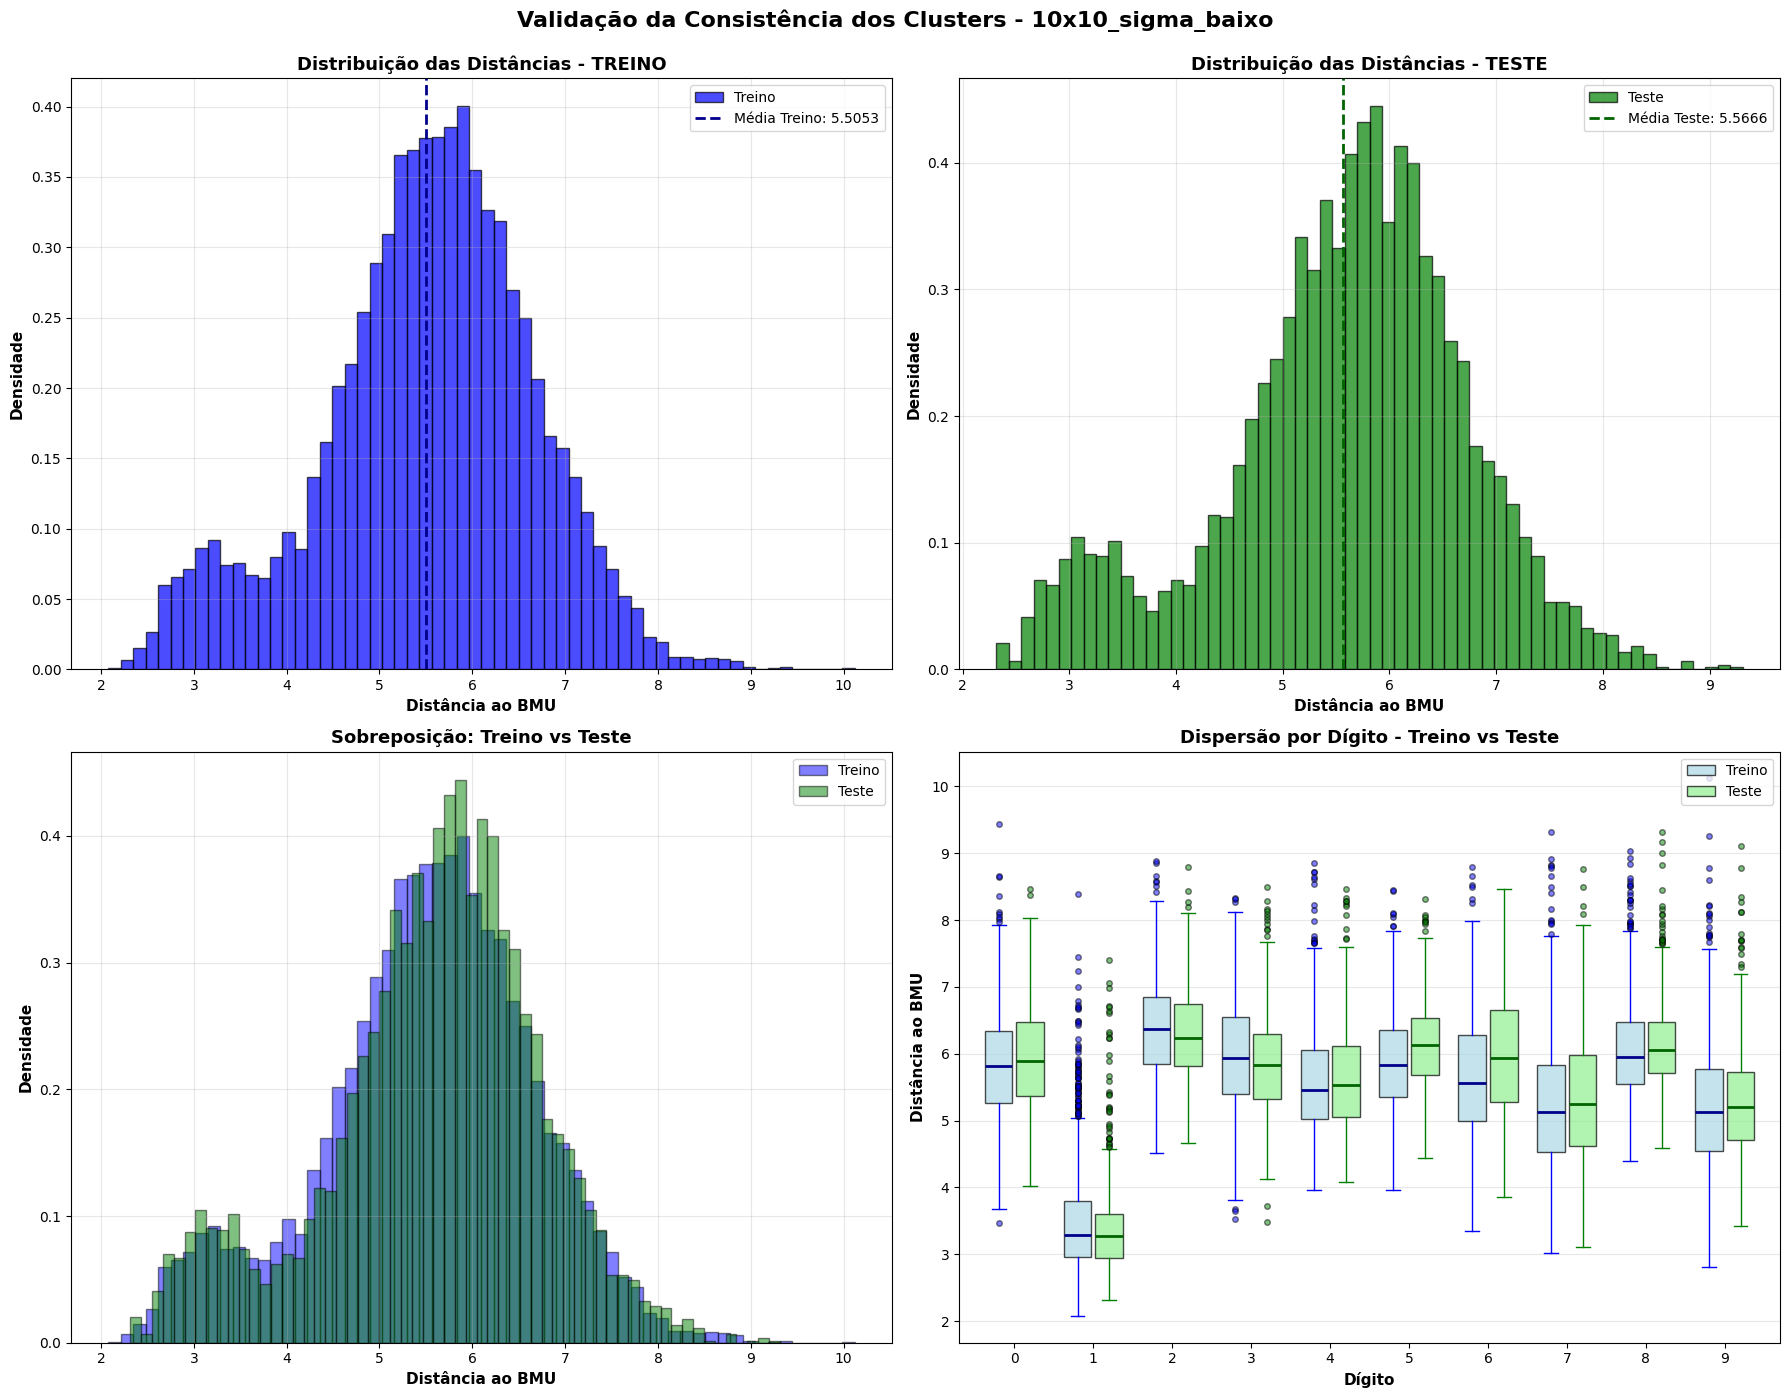

In [25]:
best_config_name = results_df.loc[results_df['silhouette'].idxmax(), 'name']
best_som_data = trained_soms[best_config_name]
best_som = best_som_data['som']

X_test_sample = X_mnist_flat[60000:65000]
y_test_sample = y_mnist_full[60000:65000]

bmu_map_test = best_som.get_bmu_map(X_test_sample)

distances_train = calculate_bmu_distances(best_som, X_mnist_sample)
distances_test = calculate_bmu_distances(best_som, X_test_sample)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

axes[0, 0].hist(distances_train, bins=60, alpha=0.7, color='blue', edgecolor='black', label='Treino', density=True)
axes[0, 0].axvline(distances_train.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Média Treino: {distances_train.mean():.4f}')
axes[0, 0].set_xlabel('Distância ao BMU', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Densidade', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribuição das Distâncias - TREINO', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(distances_test, bins=60, alpha=0.7, color='green', edgecolor='black', label='Teste', density=True)
axes[0, 1].axvline(distances_test.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Média Teste: {distances_test.mean():.4f}')
axes[0, 1].set_xlabel('Distância ao BMU', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Densidade', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribuição das Distâncias - TESTE', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(distances_train, bins=60, alpha=0.5, color='blue', edgecolor='black', label='Treino', density=True)
axes[1, 0].hist(distances_test, bins=60, alpha=0.5, color='green', edgecolor='black', label='Teste', density=True)
axes[1, 0].set_xlabel('Distância ao BMU', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Densidade', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Sobreposição: Treino vs Teste', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

train_distances_by_digit = [distances_train[y_mnist_sample == d] for d in range(10)]
test_distances_by_digit = [distances_test[y_test_sample == d] for d in range(10)]

positions = np.arange(10)
bp_train = axes[1, 1].boxplot(train_distances_by_digit, positions=positions - 0.2, widths=0.35,
                               patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7),
                               medianprops=dict(color='darkblue', linewidth=2),
                               whiskerprops=dict(color='blue'),
                               capprops=dict(color='blue'),
                               flierprops=dict(marker='o', markerfacecolor='blue', markersize=4, alpha=0.5))

bp_test = axes[1, 1].boxplot(test_distances_by_digit, positions=positions + 0.2, widths=0.35,
                              patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7),
                              medianprops=dict(color='darkgreen', linewidth=2),
                              whiskerprops=dict(color='green'),
                              capprops=dict(color='green'),
                              flierprops=dict(marker='o', markerfacecolor='green', markersize=4, alpha=0.5))

axes[1, 1].set_xlabel('Dígito', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Distância ao BMU', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Dispersão por Dígito - Treino vs Teste', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(positions)
axes[1, 1].set_xticklabels(range(10))
axes[1, 1].legend([bp_train["boxes"][0], bp_test["boxes"][0]], ['Treino', 'Teste'], loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Validação da Consistência dos Clusters - {best_config_name}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### **3.11. Detecção e Análise de Outliers**
Identificação de amostras atípicas através da distância euclidiana ao BMU. Outliers são amostras que, mesmo sendo mapeadas para um neurônio, apresentam alta dissimilaridade com o vetor de pesos correspondente, indicando representação inadequada ou características únicas.

Threshold (percentil 95): 7.2739
Total de outliers detectados: 500 (5.0%)
Total de amostras normais: 9500 (95.0%)

Distância ao BMU - Estatísticas:
  Média (normal): 5.3895
  Média (outliers): 7.7064
  Máxima: 10.1181
  Mínima: 2.0792


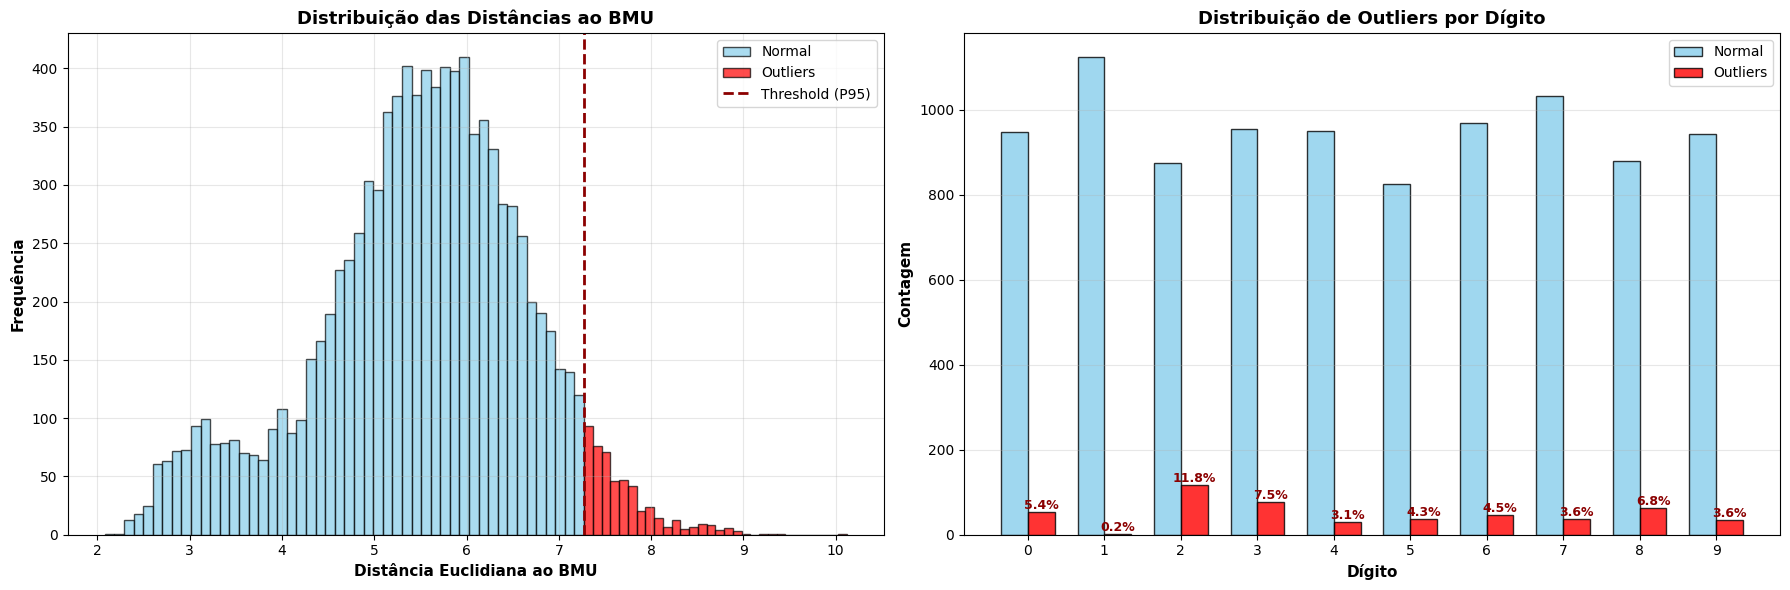

In [ ]:
def calculate_bmu_distances(som, data):
    distances = np.zeros(data.shape[0])
    
    for i, sample in enumerate(data):
        bmu_x, bmu_y = som._find_bmu(tf.constant(sample, dtype=tf.float32))
        bmu_weights = som.weights[bmu_x, bmu_y].numpy()
        distances[i] = np.linalg.norm(sample - bmu_weights)
    
    return distances

best_som_data = trained_soms[best_config_name]
best_som = best_som_data['som']

distances_train = calculate_bmu_distances(best_som, X_mnist_sample)

threshold_percentile = 95
threshold = np.percentile(distances_train, threshold_percentile) ### 

outliers_mask = distances_train > threshold
outliers_indices = np.where(outliers_mask)[0]
normal_indices = np.where(~outliers_mask)[0]

print(f"Threshold (percentil {threshold_percentile}): {threshold:.4f}")
print(f"Total de outliers detectados: {len(outliers_indices)} ({(len(outliers_indices)/len(X_mnist_sample))*100:.1f}%)")
print(f"Total de amostras normais: {len(normal_indices)} ({(len(normal_indices)/len(X_mnist_sample))*100:.1f}%)")
print(f"\nDistância ao BMU - Estatísticas:")
print(f"  Média (normal): {distances_train[normal_indices].mean():.4f}")
print(f"  Média (outliers): {distances_train[outliers_indices].mean():.4f}")
print(f"  Máxima: {distances_train.max():.4f}")
print(f"  Mínima: {distances_train.min():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].hist(distances_train[normal_indices], bins=50, alpha=0.7, color='skyblue', edgecolor='black', label='Normal')
axes[0].hist(distances_train[outliers_indices], bins=30, alpha=0.7, color='red', edgecolor='black', label='Outliers')
axes[0].axvline(threshold, color='darkred', linestyle='--', linewidth=2, label=f'Threshold (P{threshold_percentile})')
axes[0].set_xlabel('Distância Euclidiana ao BMU', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequência', fontsize=11, fontweight='bold')
axes[0].set_title('Distribuição das Distâncias ao BMU', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

outlier_digits = y_mnist_sample[outliers_indices]
normal_digits = y_mnist_sample[normal_indices]

outlier_counts = np.bincount(outlier_digits, minlength=10)
normal_counts = np.bincount(normal_digits, minlength=10)
total_counts = np.bincount(y_mnist_sample, minlength=10)

outlier_percentages = (outlier_counts / total_counts) * 100

x = np.arange(10)
width = 0.35

bars1 = axes[1].bar(x - width/2, normal_counts, width, label='Normal', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = axes[1].bar(x + width/2, outlier_counts, width, label='Outliers', alpha=0.8, color='red', edgecolor='black')

axes[1].set_xlabel('Dígito', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Contagem', fontsize=11, fontweight='bold')
axes[1].set_title('Distribuição de Outliers por Dígito', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(x)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for i, (bar, pct) in enumerate(zip(bars2, outlier_percentages)):
    height = bar.get_height()
    if height > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()


#### **Visualização dos Outliers Detectados**
Exibição visual das amostras identificadas como outliers para análise qualitativa. Estes dígitos apresentam características atípicas que dificultam seu mapeamento adequado na SOM.

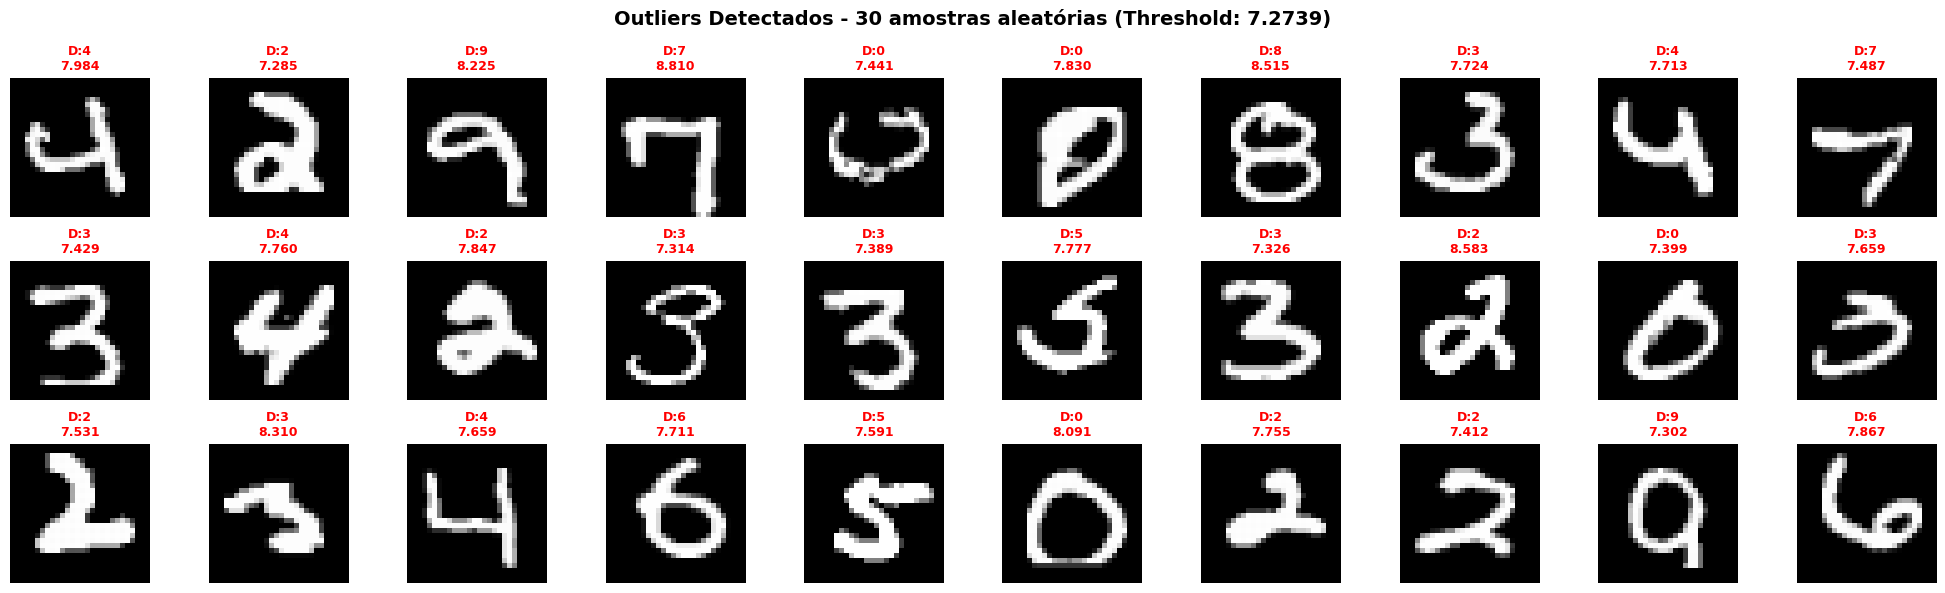

In [22]:
n_outliers_to_show = min(30, len(outliers_indices))
selected_outliers = np.random.choice(outliers_indices, n_outliers_to_show, replace=False)

fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.ravel()

for idx, outlier_idx in enumerate(selected_outliers):
    img = X_mnist_sample[outlier_idx].reshape(28, 28)
    digit = y_mnist_sample[outlier_idx]
    distance = distances_train[outlier_idx]
    
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'D:{digit}\n{distance:.3f}', fontsize=9, fontweight='bold', color='red')
    axes[idx].axis('off')

plt.suptitle(f'Outliers Detectados - 30 amostras aleatórias (Threshold: {threshold:.4f})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### **Comparação: Outliers vs Amostras Normais**
Comparação visual entre outliers e amostras normais para o mesmo dígito, evidenciando as diferenças de escrita e qualidade.

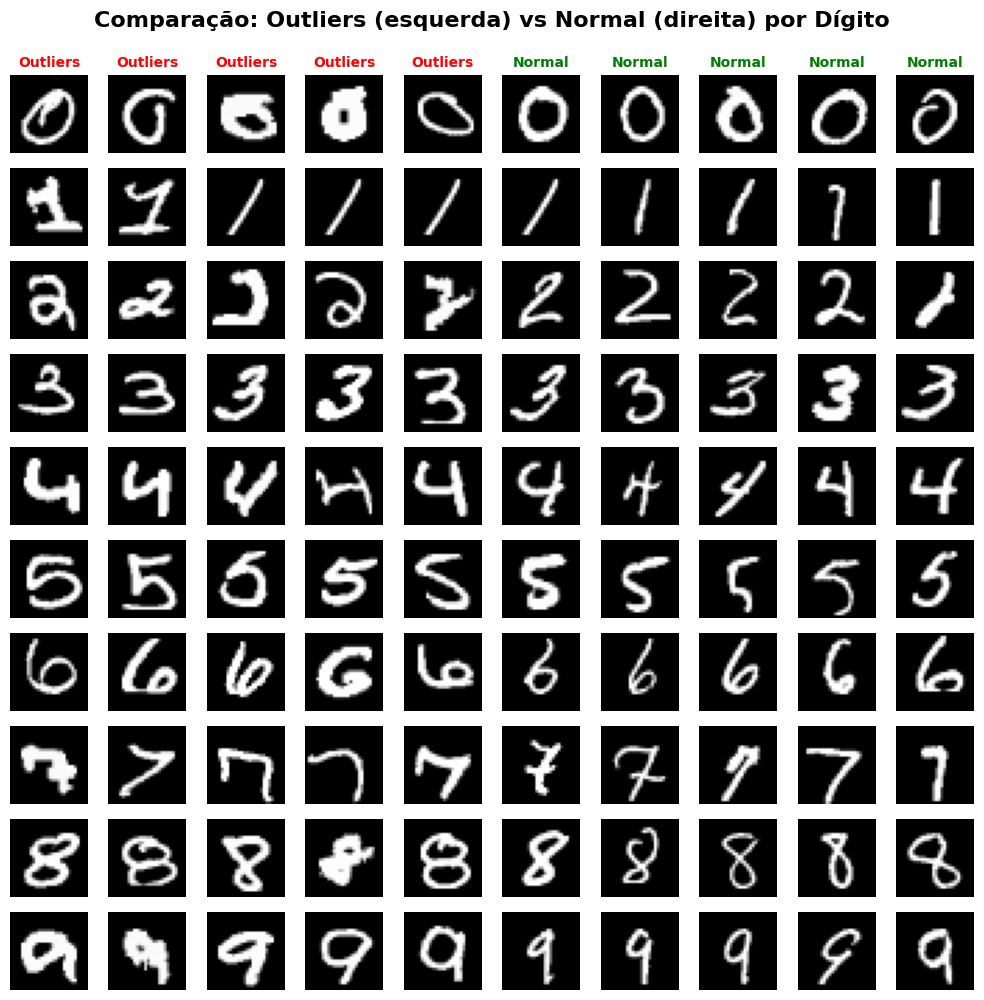

In [36]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for digit in range(10):
    digit_outliers = outliers_indices[y_mnist_sample[outliers_indices] == digit]
    digit_normal = normal_indices[y_mnist_sample[normal_indices] == digit]
    
    n_samples = min(5, len(digit_outliers))
    
    if n_samples > 0:
        selected_outliers_digit = np.random.choice(digit_outliers, n_samples, replace=False)
        selected_normal_digit = np.random.choice(digit_normal, 5, replace=False)
        
        for i in range(5):
            axes[digit, i].imshow(X_mnist_sample[selected_outliers_digit[i] if i < n_samples else selected_normal_digit[0]].reshape(28, 28), cmap='gray')
            axes[digit, i].axis('off')
            if i == 0:
                axes[digit, i].set_ylabel(f'Dígito {digit}', fontsize=11, fontweight='bold', rotation=0, labelpad=40, va='center')
            if digit == 0:
                axes[digit, i].set_title('Outliers', fontsize=10, fontweight='bold', color='red')
        
        for i in range(5, 10):
            axes[digit, i].imshow(X_mnist_sample[selected_normal_digit[i-5]].reshape(28, 28), cmap='gray')
            axes[digit, i].axis('off')
            if digit == 0:
                axes[digit, i].set_title('Normal', fontsize=10, fontweight='bold', color='green')
    else:
        for i in range(10):
            axes[digit, i].axis('off')

plt.suptitle('Comparação: Outliers (esquerda) vs Normal (direita) por Dígito', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## **4. Dataset 2 - California Housing**

### **4.1. Carregamento e Pré-processamento**
Carregamento do California Housing dataset e normalização das features.

In [39]:
california_housing = fetch_california_housing()
X_housing = california_housing.data
y_housing = california_housing.target
feature_names = california_housing.feature_names

scaler_housing = StandardScaler()
X_housing_scaled = scaler_housing.fit_transform(X_housing)

print(f"Dataset shape: {X_housing_scaled.shape}")
print(f"Features: {feature_names}")
print(f"Features range após normalização: [{X_housing_scaled.min():.2f}, {X_housing_scaled.max():.2f}]")
print(f"Target range: [{y_housing.min():.2f}, {y_housing.max():.2f}]")

Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Features range após normalização: [-2.39, 119.42]
Target range: [0.15, 5.00]


### **4.2. Análise Exploratória dos Dados**
Visualização da distribuição das features e correlações.

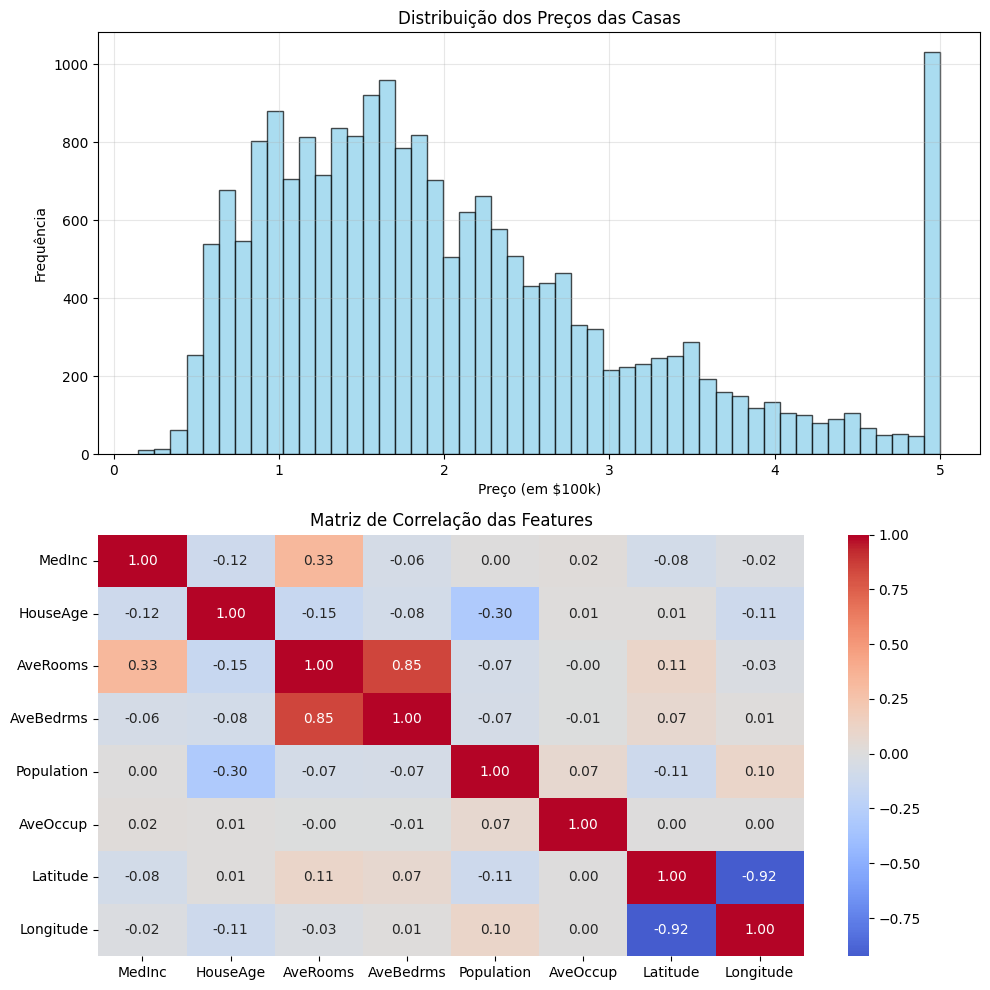


Estatísticas do dataset (após normalização):
      Feature  Mean  Std    Min      Max
0      MedInc   0.0  1.0 -1.774    5.858
1    HouseAge   0.0  1.0 -2.196    1.856
2    AveRooms   0.0  1.0 -1.852   55.163
3   AveBedrms  -0.0  1.0 -1.611   69.572
4  Population  -0.0  1.0 -1.256   30.250
5    AveOccup   0.0  1.0 -0.229  119.419
6    Latitude   0.0  1.0 -1.448    2.958
7   Longitude  -0.0  1.0 -2.386    2.625


In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.hist(y_housing, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribuição dos Preços das Casas')
ax1.set_xlabel('Preço (em $100k)')
ax1.set_ylabel('Frequência')
ax1.grid(True, alpha=0.3)

df_housing = pd.DataFrame(X_housing, columns=feature_names)
correlation_matrix = df_housing.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax2)
ax2.set_title('Matriz de Correlação das Features')

plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    'Feature': feature_names,
    'Mean': np.mean(X_housing_scaled, axis=0),
    'Std': np.std(X_housing_scaled, axis=0),
    'Min': np.min(X_housing_scaled, axis=0),
    'Max': np.max(X_housing_scaled, axis=0)
})

print("\nEstatísticas do dataset (após normalização):")
print(stats.round(3))

### **4.3. Configuração dos Experimentos - California Housing**
Configurações de SOM ajustadas para dataset com 8 features. Utilizando 6 configurações (2 por tamanho de grid) com parâmetros adaptados para menor dimensionalidade.

In [42]:
som_configs_housing = [
    {"name": "10x10_balanced", "grid_size": (10, 10), "initial_sigma": 5.0, "sigma_final": 1.0, "learning_rate": 0.5, "iterations": 10000},
    {"name": "10x10_fast", "grid_size": (10, 10), "initial_sigma": 3.0, "sigma_final": 0.5, "learning_rate": 0.7, "iterations": 5000},
    
    {"name": "15x15_balanced", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.5, "learning_rate": 0.5, "iterations": 15000},
    {"name": "15x15_high_res", "grid_size": (15, 15), "initial_sigma": 7.5, "sigma_final": 1.0, "learning_rate": 0.4, "iterations": 20000},
    
    {"name": "20x20_balanced", "grid_size": (20, 20), "initial_sigma": 10.0, "sigma_final": 2.0, "learning_rate": 0.5, "iterations": 20000},
    {"name": "20x20_fine_grain", "grid_size": (20, 20), "initial_sigma": 8.0, "sigma_final": 1.5, "learning_rate": 0.3, "iterations": 25000},
]

### **4.4. Treinamento das Configurações - California Housing**
Treinamento das 6 configurações selecionadas no dataset completo (20.640 amostras).

In [43]:
results_housing = []
trained_soms_housing = {}

for idx, config in enumerate(som_configs_housing, 1):
    print(f"\n[{idx}/{len(som_configs_housing)}] Treinando: {config['name']}")
    print(f"    Grid: {config['grid_size']}, Sigma: {config['initial_sigma']}→{config['sigma_final']}, LR: {config['learning_rate']}, Iter: {config['iterations']}")
    print("-" * 90)
    
    som = SOM(
        grid_size=config['grid_size'],
        input_dim=X_housing_scaled.shape[1],
        learning_rate=config['learning_rate'],
        initial_sigma=config['initial_sigma'],
        sigma_final=config['sigma_final']
    )
    
    start_time = time.time()
    som.train(X_housing_scaled, num_iterations=config['iterations'], verbose=False)
    training_time = time.time() - start_time
    
    bmu_map = som.get_bmu_map(X_housing_scaled)
    cluster_labels = bmu_map[:, 0] * som.grid_size[1] + bmu_map[:, 1]
    
    silhouette = silhouette_score(X_housing_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_housing_scaled, cluster_labels)
    calinski = calinski_harabasz_score(X_housing_scaled, cluster_labels)
    
    active_neurons = len(np.unique(cluster_labels))
    total_neurons = config['grid_size'][0] * config['grid_size'][1]
    utilization = (active_neurons / total_neurons) * 100
    
    result = {
        'name': config['name'],
        'grid_size': f"{config['grid_size'][0]}x{config['grid_size'][1]}",
        'initial_sigma': config['initial_sigma'],
        'sigma_final': config['sigma_final'],
        'learning_rate': config['learning_rate'],
        'iterations': config['iterations'],
        'training_time': training_time,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'active_neurons': active_neurons,
        'total_neurons': total_neurons,
        'utilization': utilization
    }
    
    results_housing.append(result)
    trained_soms_housing[config['name']] = {
        'som': som,
        'bmu_map': bmu_map,
        'cluster_labels': cluster_labels
    }
    
    print(f"    ✓ Concluído em {training_time:.2f}s")
    print(f"    Métricas: Silhouette={silhouette:.4f}, Davies-Bouldin={davies_bouldin:.4f}, Calinski={calinski:.2f}")
    print(f"    Utilização: {active_neurons}/{total_neurons} neurônios ({utilization:.1f}%)")

print("\n" + "=" * 90)
print("TREINAMENTO COMPLETO - CALIFORNIA HOUSING!")
print("=" * 90)


[1/6] Treinando: 10x10_balanced
    Grid: (10, 10), Sigma: 5.0→1.0, LR: 0.5, Iter: 10000
------------------------------------------------------------------------------------------
    ✓ Concluído em 5.72s
    Métricas: Silhouette=-0.0021, Davies-Bouldin=2.3503, Calinski=366.70
    Utilização: 100/100 neurônios (100.0%)

[2/6] Treinando: 10x10_fast
    Grid: (10, 10), Sigma: 3.0→0.5, LR: 0.7, Iter: 5000
------------------------------------------------------------------------------------------
    ✓ Concluído em 3.12s
    Métricas: Silhouette=0.0482, Davies-Bouldin=2.1537, Calinski=513.19
    Utilização: 100/100 neurônios (100.0%)

[3/6] Treinando: 15x15_balanced
    Grid: (15, 15), Sigma: 7.5→1.5, LR: 0.5, Iter: 15000
------------------------------------------------------------------------------------------
    ✓ Concluído em 8.16s
    Métricas: Silhouette=-0.0286, Davies-Bouldin=2.7451, Calinski=198.78
    Utilização: 225/225 neurônios (100.0%)

[4/6] Treinando: 15x15_high_res
    Gri

### **4.5. Mapas de Features Dominantes**
Visualização das features que apresentam maior ativação em cada neurônio. Permite identificar regiões especializadas em características específicas (renda, idade das casas, localização, etc.).

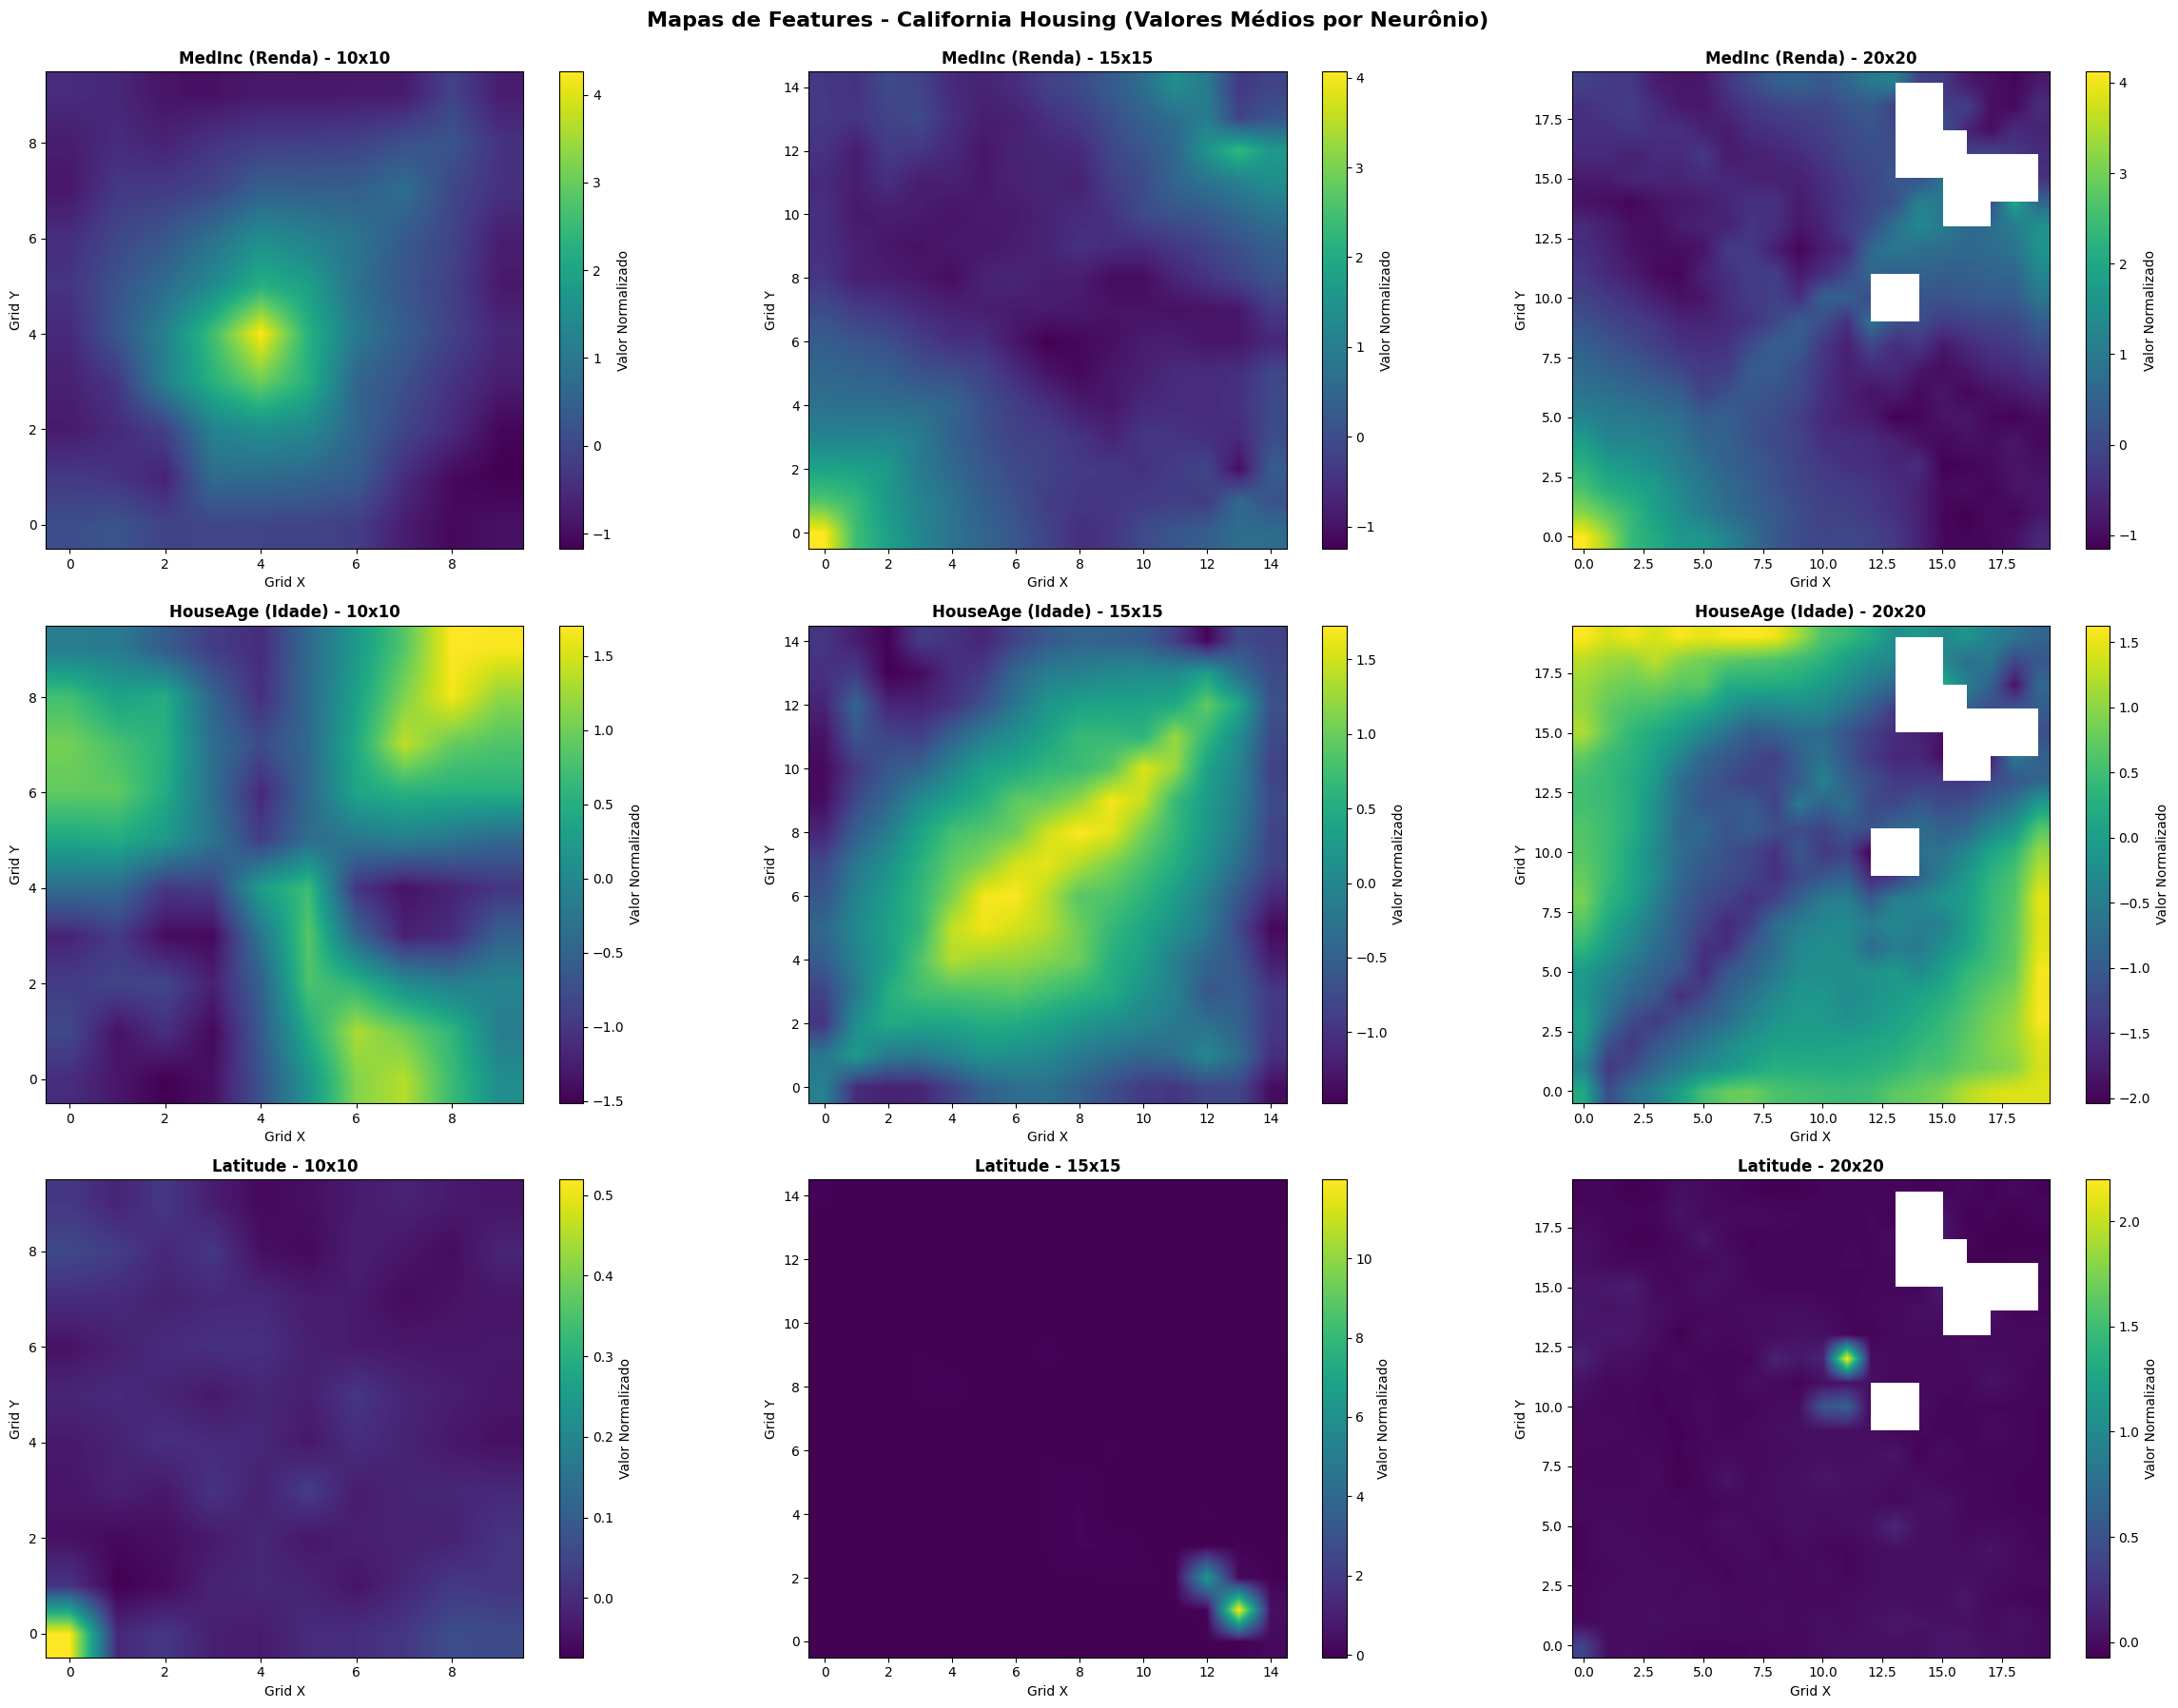

In [46]:
selected_configs_housing = ['10x10_balanced', '15x15_balanced', '20x20_balanced']
grid_labels_housing = ['10x10', '15x15', '20x20']

selected_features = [0, 1, 5]
feature_labels = ['MedInc (Renda)', 'HouseAge (Idade)', 'Latitude']

fig, axes = plt.subplots(3, 3, figsize=(24, 18))

for row_idx, feature_idx in enumerate(selected_features):
    for col_idx, config_name in enumerate(selected_configs_housing):
        data = trained_soms_housing[config_name]
        som_obj = data['som']
        bmu_map = data['bmu_map']
        
        feature_map = np.full(som_obj.grid_size, np.nan)
        
        for i in range(som_obj.grid_size[0]):
            for j in range(som_obj.grid_size[1]):
                neuron_mask = (bmu_map[:, 0] == i) & (bmu_map[:, 1] == j)
                if neuron_mask.sum() > 0:
                    feature_values = X_housing_scaled[neuron_mask, feature_idx]
                    feature_map[i, j] = np.mean(feature_values)
        
        im = axes[row_idx, col_idx].imshow(feature_map, cmap='viridis', interpolation='bilinear', origin='lower')
        axes[row_idx, col_idx].set_title(f'{feature_labels[row_idx]} - {grid_labels_housing[col_idx]}', 
                            fontsize=12, fontweight='bold')
        axes[row_idx, col_idx].set_xlabel('Grid X', fontsize=10)
        axes[row_idx, col_idx].set_ylabel('Grid Y', fontsize=10)
        plt.colorbar(im, ax=axes[row_idx, col_idx], label='Valor Normalizado')

plt.suptitle('Mapas de Features - California Housing (Valores Médios por Neurônio)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### **4.6. Visualização Geográfica dos Clusters**
Mapa da Califórnia colorido por clusters identificados pela SOM. Permite visualizar padrões geográficos e regionais nos agrupamentos.

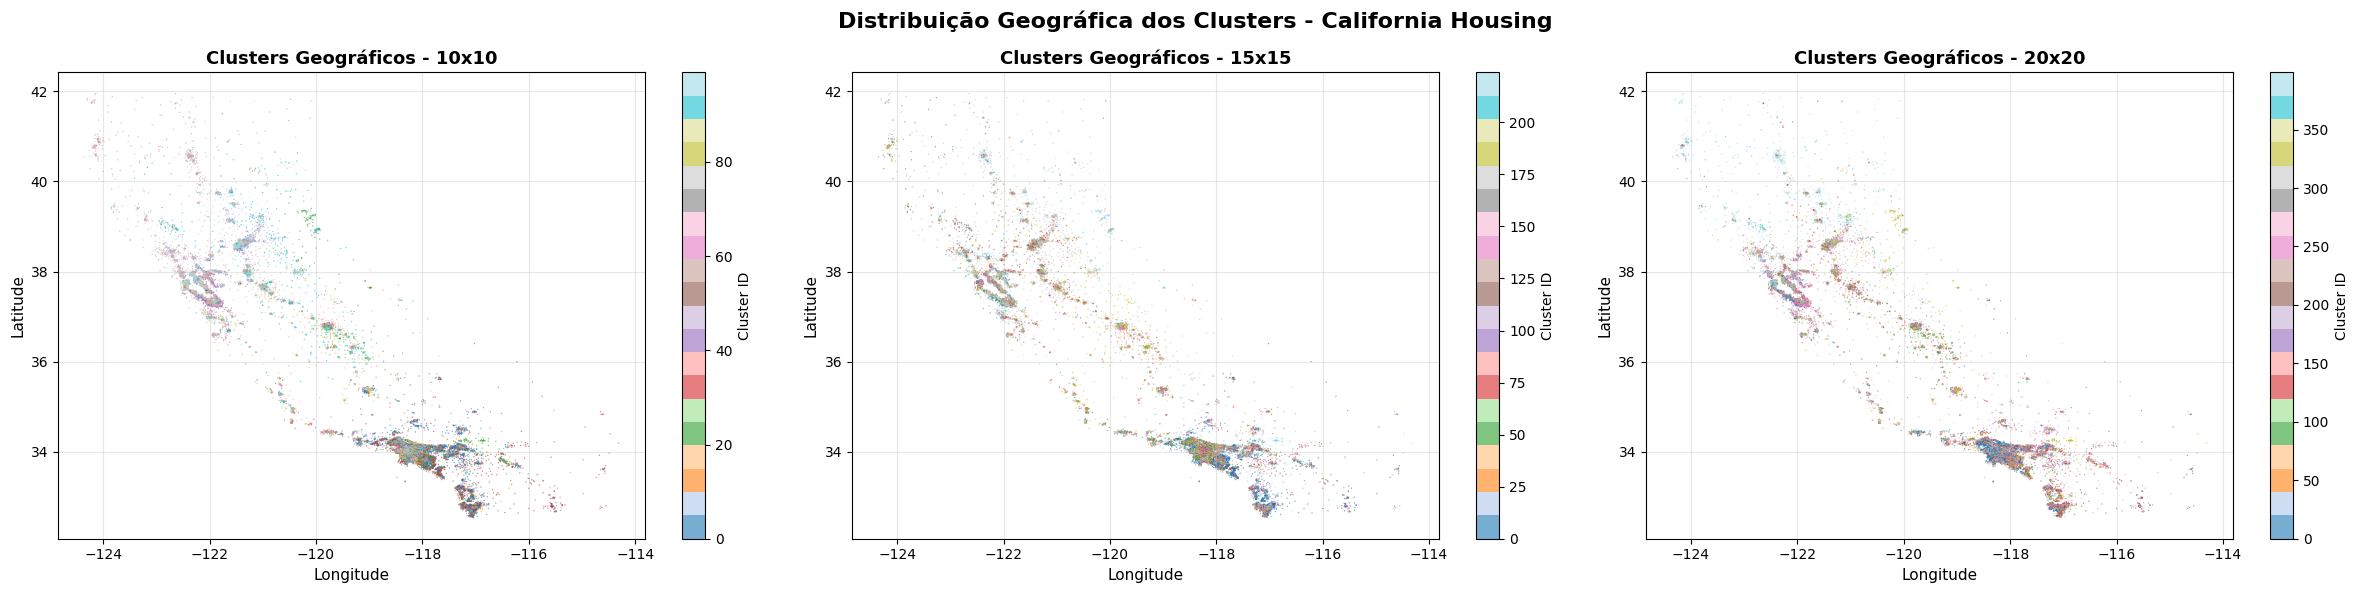

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

lat_idx = feature_names.index('Latitude')
lon_idx = feature_names.index('Longitude')

latitudes = X_housing[:, lat_idx]
longitudes = X_housing[:, lon_idx]

for idx, config_name in enumerate(selected_configs_housing):
    data = trained_soms_housing[config_name]
    cluster_labels = data['cluster_labels']
    
    scatter = axes[idx].scatter(longitudes, latitudes, c=cluster_labels, 
                               cmap='tab20', s=1, alpha=0.6, edgecolors='none')
    axes[idx].set_title(f'Clusters Geográficos - {grid_labels_housing[idx]}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Longitude', fontsize=11)
    axes[idx].set_ylabel('Latitude', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster ID')

plt.suptitle('Distribuição Geográfica dos Clusters - California Housing', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **4.7. U-Matrix - California Housing**
Matriz de distâncias unificada mostrando fronteiras entre regiões homogêneas do mapa.

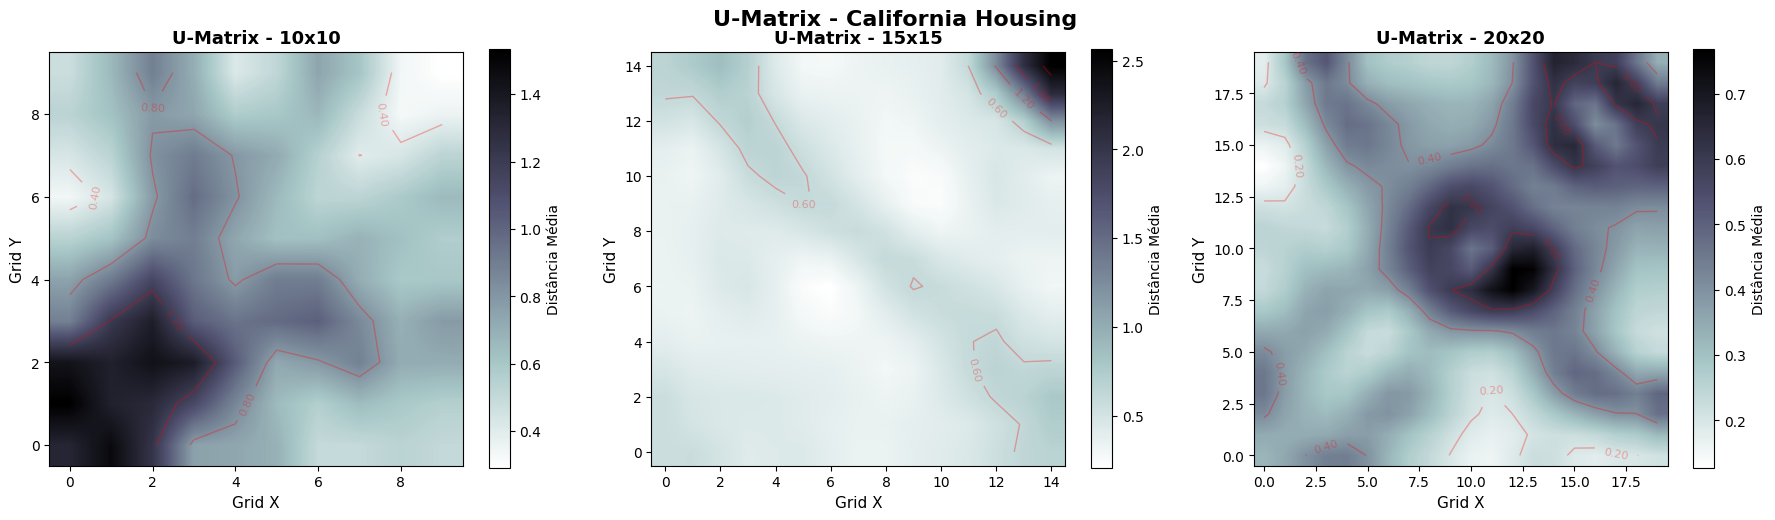

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, config_name in enumerate(selected_configs_housing):
    data = trained_soms_housing[config_name]
    som_obj = data['som']
    
    u_matrix = som_obj.calculate_u_matrix()
    
    im = axes[idx].imshow(u_matrix, cmap='bone_r', interpolation='bilinear', origin='lower')
    axes[idx].set_title(f'U-Matrix - {grid_labels_housing[idx]}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Grid X', fontsize=11)
    axes[idx].set_ylabel('Grid Y', fontsize=11)
    plt.colorbar(im, ax=axes[idx], label='Distância Média')
    
    contours = axes[idx].contour(u_matrix, levels=3, colors='red', alpha=0.3, linewidths=1)
    axes[idx].clabel(contours, inline=True, fontsize=8, fmt='%.2f')

plt.suptitle('U-Matrix - California Housing', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **4.8. Análise Comparativa de Métricas**
Comparação quantitativa das configurações treinadas no California Housing.

In [50]:
results_housing_df = pd.DataFrame(results_housing)

print("=" * 140)
print("RESUMO COMPARATIVO - CALIFORNIA HOUSING")
print("=" * 140)
print(results_housing_df.to_string(index=False))
print("=" * 140)

results_housing_sorted = results_housing_df.sort_values('silhouette', ascending=False)
print("\nMELHOR CONFIGURAÇÃO (Silhouette Score):")
print(results_housing_sorted[['name', 'grid_size', 'silhouette', 'davies_bouldin', 'utilization']].head(1).to_string(index=False))

RESUMO COMPARATIVO - CALIFORNIA HOUSING
            name grid_size  initial_sigma  sigma_final  learning_rate  iterations  training_time  silhouette  davies_bouldin  calinski_harabasz  active_neurons  total_neurons  utilization
  10x10_balanced     10x10            5.0          1.0            0.5       10000       5.723623   -0.002074        2.350296         366.697138             100            100   100.000000
      10x10_fast     10x10            3.0          0.5            0.7        5000       3.119060    0.048241        2.153693         513.185515             100            100   100.000000
  15x15_balanced     15x15            7.5          1.5            0.5       15000       8.156645   -0.028577        2.745129         198.776752             225            225   100.000000
  15x15_high_res     15x15            7.5          1.0            0.4       20000      11.488411    0.002882        2.374089         263.948287             222            225    98.666667
  20x20_balanced    

### **4.9. Análise Geográfica: Renda vs Localização**
Análise da relação entre renda mediana (MedInc) e localização geográfica (Latitude/Longitude), revelando padrões socioeconômicos regionais identificados pela SOM.

/tmp/ipykernel_4878/3045446704.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(['Latitude_Region', 'Longitude_Region'])['Income'].mean().unstack()


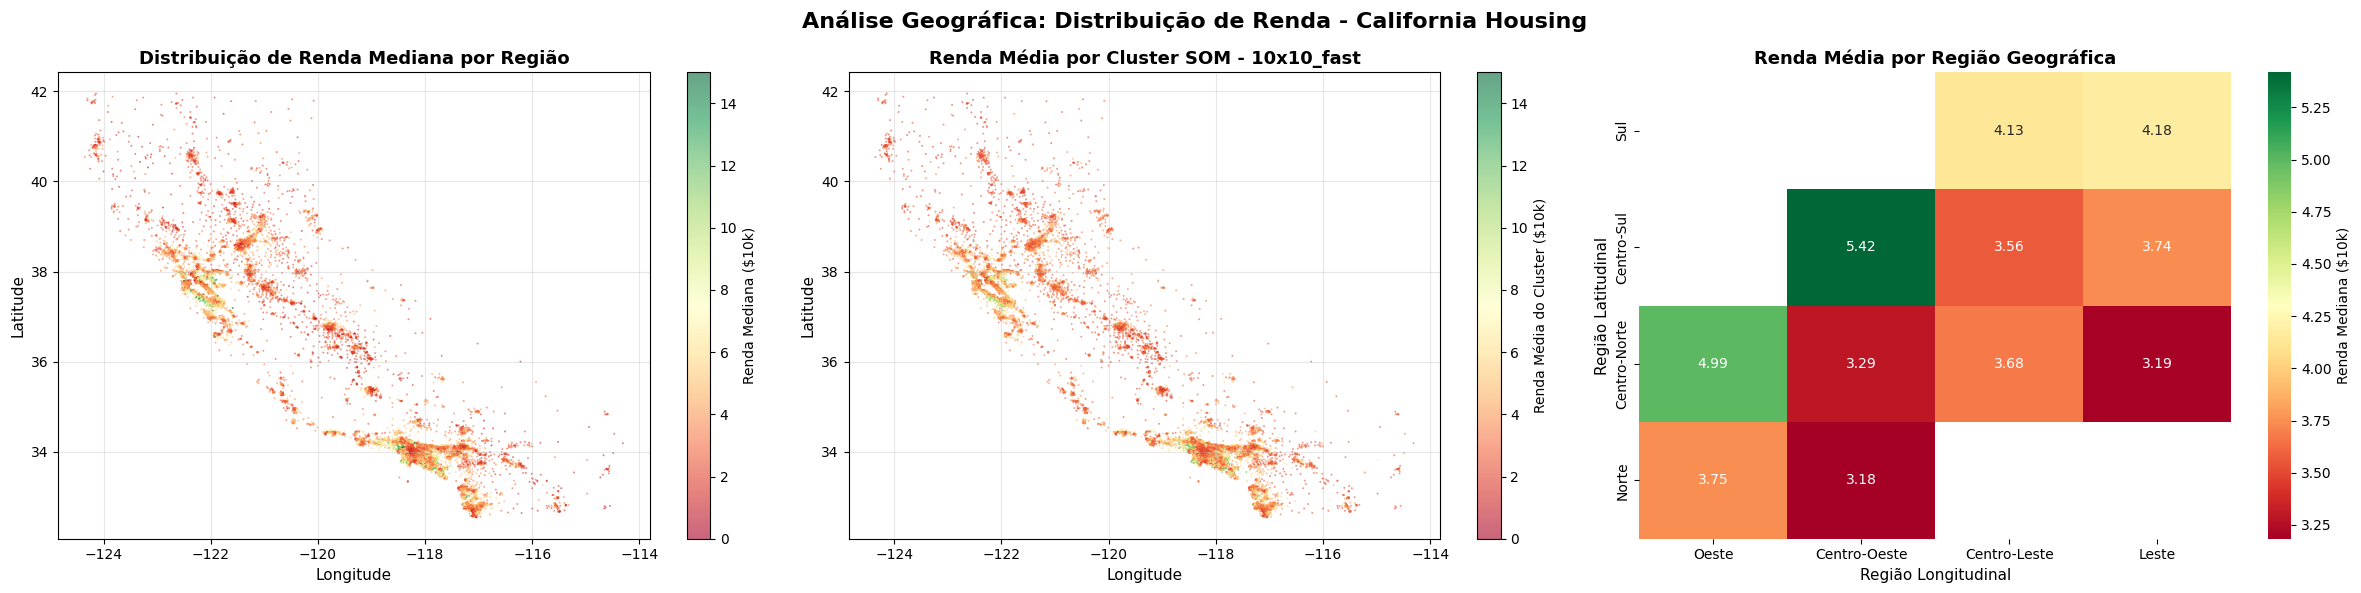

In [59]:
best_config_name_housing = results_housing_df.loc[results_housing_df['silhouette'].idxmax(), 'name']
best_som_data_housing = trained_soms_housing[best_config_name_housing]

medinc_idx = feature_names.index('MedInc')
income_values = X_housing[:, medinc_idx]

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

scatter1 = axes[0].scatter(longitudes, latitudes, c=income_values, 
                          cmap='RdYlGn', s=2, alpha=0.6, edgecolors='none', vmin=0, vmax=15)
axes[0].set_title('Distribuição de Renda Mediana por Região', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Longitude', fontsize=11)
axes[0].set_ylabel('Latitude', fontsize=11)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='MedInc ($10k)')
cbar1.set_label('Renda Mediana ($10k)', fontsize=10)

cluster_labels_best = best_som_data_housing['cluster_labels']
cluster_income_means = []
for cluster_id in np.unique(cluster_labels_best):
    cluster_mask = cluster_labels_best == cluster_id
    cluster_income_means.append(income_values[cluster_mask].mean())

cluster_income_map = np.array([cluster_income_means[label] for label in cluster_labels_best])

scatter2 = axes[1].scatter(longitudes, latitudes, c=cluster_income_map, 
                          cmap='RdYlGn', s=2, alpha=0.6, edgecolors='none', vmin=0, vmax=15)
axes[1].set_title(f'Renda Média por Cluster SOM - {best_config_name_housing}', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Longitude', fontsize=11)
axes[1].set_ylabel('Latitude', fontsize=11)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='MedInc ($10k)')
cbar2.set_label('Renda Média do Cluster ($10k)', fontsize=10)

income_bins = pd.cut(income_values, bins=5, labels=['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta'])
income_categories = income_bins.codes

lat_bins = pd.qcut(latitudes, q=4, labels=['Sul', 'Centro-Sul', 'Centro-Norte', 'Norte'], duplicates='drop')
lon_bins = pd.qcut(longitudes, q=4, labels=['Oeste', 'Centro-Oeste', 'Centro-Leste', 'Leste'], duplicates='drop')

region_income = pd.DataFrame({
    'Latitude_Region': lat_bins,
    'Longitude_Region': lon_bins,
    'Income': income_values
}).groupby(['Latitude_Region', 'Longitude_Region'])['Income'].mean().unstack()

sns.heatmap(region_income, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[2], 
            cbar_kws={'label': 'Renda Mediana ($10k)'})
axes[2].set_title('Renda Média por Região Geográfica', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Região Longitudinal', fontsize=11)
axes[2].set_ylabel('Região Latitudinal', fontsize=11)

plt.suptitle('Análise Geográfica: Distribuição de Renda - California Housing', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()